0. flow 전처리 (IQR, Savgol)
1. weather 전처리 
2. flow & weather merge
3. sliding window
4. train / val / test
5. 정규화 (train만) ,  y는 value scaler로 정규화
6. LSTM

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd

### Data Split 구조 (4계절 Block Sampling, 60일 x 4)

각 블록(60일)을 시간 순서대로 70 / 15 / 15로 분할 (블록 간 87분 gap으로 data leak 방지)

| 계절 | Train (~42일) | Val (~9일) | Test (~9일) |
|------|--------------|-------------|--------------|
| Winter | 23/12/01 ~ 24/01/11 | 24/01/11 ~ 24/01/20 | 24/01/20 ~ 24/01/29 |
| Spring | 24/03/15 ~ 24/04/25 | 24/04/25 ~ 24/05/04 | 24/05/04 ~ 24/05/13 |
| Summer | 23/07/01 ~ 23/08/11 | 23/08/11 ~ 23/08/20 | 23/08/20 ~ 23/08/29 |
| Fall | 23/09/15 ~ 23/10/26 | 23/10/26 ~ 23/11/04 | 23/11/04 ~ 23/11/13 |

**예측 구조:** 72분 입력 (10 features) -> 15분 예측 (flow value) x 4 rolling = 1시간

**모델:** LSTM Seq2Seq + **Bahdanau Attention** — 전체 Hidden Sequence 활용
- **기존 Cross-Attention 실패 원인:**
  - Query = h₇₂ (고정) → 모든 step이 동일한 가중치(1/72) → Attention 무효
- **Bahdanau Attention 해결:**
  - Query = **Decoder의 현재 step hidden state** (step마다 다름)
  - step 1의 Query ≠ step 15의 Query → step별로 다른 곳을 참조
- **Model B(Autoreg) 실패와의 차이:**
  - Model B: prev_pred 피드백 → error accumulation + Scheduled Sampling 필요
  - **이 모델: step_embed 입력 → error 격리 + Teacher forcing 불필요**

**Loss:** Step-weighted MSE (step 1=1.0 -> step 15=2.0)
**LR Scheduler:** ReduceLROnPlateau (factor=0.5, patience=3)

0. flow, weather 데이터 Load

In [2]:
BASE_DIR = Path.cwd().parent

# Flow raw data 로드 (J배수지, reservoir/10.csv)
flow_file = BASE_DIR / "data" / "rawdata" / "reservoir" / "10.csv"
df_flow = pd.read_csv(
    flow_file,
    header=None,
    usecols=[1, 2],
    names=['time', 'value']
).sort_values('time').reset_index(drop=True)

df_flow['time'] = pd.to_datetime(df_flow['time'], errors='coerce')
df_flow = df_flow.dropna(subset=['time'])
print(f"Flow 원본: {len(df_flow):,}개 ({df_flow['time'].min()} ~ {df_flow['time'].max()})")

# Weather 파일 경로
weather_file = BASE_DIR / "data" / "rawdata" / "weather"

Flow 원본: 943,434개 (2023-01-01 00:01:00 ~ 2024-10-17 17:19:00)


0-1. Flow 전처리
- IQR 이상치 + 음수 + 급변동 제거 → NaN
- Linear interpolation (양방향)
- Savitzky-Golay filter (window=51, polyorder=2)

In [3]:
from scipy.signal import savgol_filter

# 1. IQR 이상치 + 음수 + 급변동 → NaN 처리
Q1 = df_flow['value'].quantile(0.25)
Q3 = df_flow['value'].quantile(0.75)
IQR = Q3 - Q1

iqr_mask = (df_flow['value'] < Q1 - 1.5 * IQR) | (df_flow['value'] > Q3 + 1.5 * IQR)
negative_mask = df_flow['value'] < 0
diff = df_flow['value'].diff().abs()
spike_threshold = diff.quantile(0.999)
spike_mask = diff > spike_threshold

total_mask = iqr_mask | negative_mask | spike_mask
df_flow.loc[total_mask, 'value'] = np.nan

print(f"이상치 제거: IQR={iqr_mask.sum()}, 음수={negative_mask.sum()}, "
      f"급변동(>{spike_threshold:.2f})={spike_mask.sum()}, 총={total_mask.sum()}")

# 2. Linear interpolation (양방향) + clip
df_flow['value'] = df_flow['value'].interpolate(method='linear', limit_direction='both')
df_flow['value'] = df_flow['value'].clip(lower=0)

# 3. Savitzky-Golay filter (노이즈 제거, window=51, polyorder=2)
df_flow['value'] = savgol_filter(df_flow['value'], window_length=51, polyorder=2)
df_flow['value'] = df_flow['value'].clip(lower=0)

print(f"전처리 완료: {len(df_flow):,}개, "
      f"범위 [{df_flow['value'].min():.2f}, {df_flow['value'].max():.2f}]")

이상치 제거: IQR=21, 음수=0, 급변동(>91.06)=944, 총=962
전처리 완료: 943,434개, 범위 [0.00, 325.52]


In [4]:
# 전처리 결과 저장 (원본 보호 + 재현성)
save_path = BASE_DIR / "data" / "processed" / "flow_preprocessed.csv"
df_flow.to_csv(save_path, index=False)
print(f"저장 완료: {save_path} ({len(df_flow):,}행)")

저장 완료: /home/kp/web/work/pro/data/processed/flow_preprocessed.csv (943,434행)


- weather 데이터 인코딩, concat

In [5]:
def read_weather_csv(f):
    for enc in ["euc-kr", "cp949", "utf-8", "utf-8-sig"]:
        try:
            return pd.read_csv(f, encoding=enc)
        except (UnicodeDecodeError, UnicodeError):
            continue
    raise ValueError(f"인코딩 실패: {f.name}")

files = sorted(weather_file.glob("*.csv"))
print(f"읽을 파일 수: {len(files)}")

weather = pd.concat(
    [read_weather_csv(f) for f in files],
    ignore_index=True
)
print(f"concat 후 행 수: {len(weather):,}")

읽을 파일 수: 22
concat 후 행 수: 942,510


- 데이터 저장

In [6]:
# weather 전체 concat 결과 저장 (원본 보호)
weather.to_csv(BASE_DIR / "data" / "processed" / "weather_total_raw.csv", index=False, encoding="utf-8-sig")

1. weather 전처리

In [7]:
weather['일시'] = pd.to_datetime(weather['일시'])

# 결측 처리: 강수량 0 채움, 기온/습도 linear 보간 (최대 60분 gap)
weather['0.5mm 일 누적 강수량(mm)'] = weather['0.5mm 일 누적 강수량(mm)'].fillna(0)
weather['기온(℃)'] = weather['기온(℃)'].interpolate(method='linear', limit=60)
weather['상대습도(%)'] = weather['상대습도(%)'].interpolate(method='linear', limit=60)

# 장기 결측(>60분) 행 제거 — LSTM이 가짜 패턴 학습 방지
before = len(weather)
weather = weather.dropna(subset=['기온(℃)', '상대습도(%)'])
print(f'장기 결측 제거: {before:,} -> {len(weather):,} ({len(weather)/before*100:.1f}% 유지)')

weather = weather.rename(columns={
    '일시': 'datetime',
    '기온(℃)': 'temperature',
    '0.5mm 일 누적 강수량(mm)': 'rainfall',
    '상대습도(%)': 'humidity',
})

# 중복 timestamp 제거 (첫 번째 행 유지)
weather = weather.drop_duplicates(subset='datetime', keep='first')
weather = weather.sort_values('datetime').reset_index(drop=True)

# 시간 불연속 경계 표시 — segment 단위 sliding window용
time_diff = weather['datetime'].diff()
seg_boundary = time_diff > pd.Timedelta(minutes=1)
weather['segment_id'] = seg_boundary.cumsum()
print(f'연속 세그먼트 수: {weather["segment_id"].nunique()}')

print(weather.shape)
print(weather.head())

장기 결측 제거: 942,510 -> 894,039 (94.9% 유지)
연속 세그먼트 수: 3564
(894039, 5)
             datetime  temperature  rainfall  humidity  segment_id
0 2023-01-01 00:01:00         -3.3       0.0      91.6           0
1 2023-01-01 00:02:00         -3.3       0.0      91.6           0
2 2023-01-01 00:03:00         -3.3       0.0      91.6           0
3 2023-01-01 00:04:00         -3.2       0.0      91.6           0
4 2023-01-01 00:05:00         -3.2       0.0      91.6           0


In [8]:
weather.describe()

,datetime,temperature,rainfall,humidity,segment_id
count,894039,894039.000000,894039.000000,894039.000000,894039.000000
mean,2023-12-09 07:18:45.749011,15.358957,1.922265,71.807508,1596.019969
min,2023-01-01 00:01:00,-16.500000,0.000000,2.900000,0.000000
25%,2023-07-03 09:58:30,6.300000,0.000000,57.200000,465.000000
50%,2023-12-13 20:09:00,16.500000,0.000000,76.000000,1066.000000
75%,2024-05-25 11:14:30,24.700000,0.000000,90.300000,3267.000000
max,2024-11-01 00:00:00,37.700000,160.000000,99.900000,3563.000000
std,NaN,10.908432,8.737307,21.188111,1320.075920


In [9]:
df = pd.DataFrame(weather)
df.isnull().sum()

datetime       0
temperature    0
rainfall       0
humidity       0
segment_id     0
dtype: int64

- rainfall: 시간별 누적 강우량 → 원본 값이 물리적 의미(총 유입량)를 가지므로 분포 변환 없이 MinMaxScaler만 적용

In [10]:
df_weather = df[['datetime', 'temperature', 'rainfall', 'humidity', 'segment_id']].copy()

2-1. weather data merge
2-2. weather, time feature 추가

In [11]:
df_merged = pd.merge(df_flow, df_weather, how='inner', left_on='time', right_on="datetime")

In [12]:
df_merged = df_merged.drop(columns=['datetime'])

# 1분 단위 유지 (리샘플링 없음)
df_merged = df_merged.sort_values('time').reset_index(drop=True)
df_merged = df_merged.dropna()
print(f"데이터: {len(df_merged):,}개 (1분 단위)")

# ★ merge 후 시간 불연속 경계 재계산 (weather segment_id 대체)
# weather의 segment_id는 weather 단독 기준이므로,
# flow+weather inner merge 후 실제 불연속을 반영해야 정확함
time_diff_merged = df_merged['time'].diff()
seg_boundary_merged = time_diff_merged > pd.Timedelta(minutes=1)
df_merged['segment_id'] = seg_boundary_merged.cumsum()
print(f"merge 후 연속 세그먼트 수: {df_merged['segment_id'].nunique()}")

# Cyclical temporal features
t: pd.Series = df_merged['time']

# int -> float cast for arithmetic with np.pi
hour = t.dt.hour.astype(np.float64)
minute = t.dt.minute.astype(np.float64)
dow = t.dt.dayofweek.astype(np.float64)
doy = t.dt.dayofyear.astype(np.float64)

# 시간정보 (분 단위 하루 주기, T=1440)
minute_of_day = hour * 60 + minute
df_merged['time_sin'] = 0.5 * np.sin(2 * np.pi * minute_of_day / 1440) + 0.5
df_merged['time_cos'] = 0.5 * np.cos(2 * np.pi * minute_of_day / 1440) + 0.5

# 요일 (주간 주기, T=7)
df_merged['dow_sin'] = 0.5 * np.sin(2 * np.pi * dow / 7) + 0.5
df_merged['dow_cos'] = 0.5 * np.cos(2 * np.pi * dow / 7) + 0.5

# 계절 (연간 주기, T=365.25)
df_merged['season_sin'] = 0.5 * np.sin(2 * np.pi * doy / 365.25) + 0.5
df_merged['season_cos'] = 0.5 * np.cos(2 * np.pi * doy / 365.25) + 0.5

print(f"Temporal features 추가 완료: {df_merged.shape}")
print(df_merged.head())

데이터: 872,723개 (1분 단위)
merge 후 연속 세그먼트 수: 4158
Temporal features 추가 완료: (872723, 12)
                 time      value  temperature  rainfall  humidity  segment_id  \
0 2023-01-01 00:01:00  96.577302         -3.3       0.0      91.6           0   
1 2023-01-01 00:02:00  96.739744         -3.3       0.0      91.6           0   
2 2023-01-01 00:03:00  96.895855         -3.3       0.0      91.6           0   
3 2023-01-01 00:04:00  97.045636         -3.2       0.0      91.6           0   
4 2023-01-01 00:05:00  97.189086         -3.2       0.0      91.6           0   

   time_sin  time_cos   dow_sin   dow_cos  season_sin  season_cos  
0  0.502182  0.999995  0.109084  0.811745    0.508601    0.999926  
1  0.504363  0.999981  0.109084  0.811745    0.508601    0.999926  
2  0.506545  0.999957  0.109084  0.811745    0.508601    0.999926  
3  0.508726  0.999924  0.109084  0.811745    0.508601    0.999926  
4  0.510907  0.999881  0.109084  0.811745    0.508601    0.999926  


In [13]:
df_merged.shape, df_merged.info()

<class 'pandas.DataFrame'>
RangeIndex: 872723 entries, 0 to 872722
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   time         872723 non-null  datetime64[us]
 1   value        872723 non-null  float64       
 2   temperature  872723 non-null  float64       
 3   rainfall     872723 non-null  float64       
 4   humidity     872723 non-null  float64       
 5   segment_id   872723 non-null  int64         
 6   time_sin     872723 non-null  float64       
 7   time_cos     872723 non-null  float64       
 8   dow_sin      872723 non-null  float64       
 9   dow_cos      872723 non-null  float64       
 10  season_sin   872723 non-null  float64       
 11  season_cos   872723 non-null  float64       
dtypes: datetime64[us](1), float64(10), int64(1)
memory usage: 79.9 MB


((872723, 12), None)

In [14]:
df_merged.describe()

,time,value,temperature,rainfall,humidity,segment_id,time_sin,time_cos,dow_sin,dow_cos,season_sin,season_cos
count,872723,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,872723.000000,8.727230e+05,872723.000000
mean,2023-12-01 18:39:20.141650,151.786570,15.354982,1.932336,71.595445,1853.432576,0.500568,0.498633,0.496760,0.498728,5.197144e-01,0.470201
min,2023-01-01 00:01:00,0.000000,-16.500000,0.000000,2.900000,0.000000,0.000000,0.000000,0.012536,0.049516,2.889877e-07,0.000010
25%,2023-06-27 11:00:30,109.030874,6.100000,0.000000,56.900000,613.000000,0.146447,0.144907,0.109084,0.049516,1.605898e-01,0.128500
50%,2023-12-06 15:46:00,144.881767,16.500000,0.000000,75.700000,1311.000000,0.502182,0.497818,0.500000,0.388740,5.600631e-01,0.457583
75%,2024-05-14 15:26:30,192.717293,24.800000,0.000000,90.000000,3509.000000,0.853553,0.852007,0.890916,0.811745,8.732941e-01,0.812944
max,2024-10-17 17:19:00,325.516638,37.700000,160.000000,99.900000,4157.000000,1.000000,0.999995,0.987464,1.000000,9.999928e-01,0.999926
std,NaN,56.898401,11.013743,8.825355,21.235732,1468.650283,0.353499,0.353606,0.352849,0.354239,3.565895e-01,0.348665


In [15]:
# 2-3. 계절별 Block Sampling (60일 × 4계절, 2023-2024 교차)
# 45일 대비 데이터 확대 효과 검증 (단일 변인: 기간만 변경)

season_ranges = [
    ('2023-12-01', '2024-01-29', 'Winter'),
    ('2024-03-15', '2024-05-13', 'Spring'),
    ('2023-07-01', '2023-08-29', 'Summer'),
    ('2023-09-15', '2023-11-13', 'Fall'),
]

blocks = []
for i, (start, end, name) in enumerate(season_ranges):
    mask = (df_merged['time'] >= start) & (df_merged['time'] <= end)
    block = df_merged[mask].copy()
    block['block_id'] = i
    blocks.append(block)
    print(f"[{name}] {start} ~ {end}: {len(block):,} rows")

df_merged = pd.concat(blocks, ignore_index=True)
print(f"\nTotal: {len(df_merged):,} rows (4-season block sampling, 60일 × 4)")

[Winter] 2023-12-01 ~ 2024-01-29: 80,828 rows
[Spring] 2024-03-15 ~ 2024-05-13: 78,794 rows
[Summer] 2023-07-01 ~ 2023-08-29: 83,256 rows
[Fall] 2023-09-15 ~ 2023-11-13: 80,430 rows

Total: 323,308 rows (4-season block sampling, 60일 × 4)


3. Sliding Windows 생성
- X: (n_samples, input_time, 10) — value, temperature, rainfall, humidity + 6 cyclical features
- y: (n_samples, output_time) — value만 예측

In [16]:
feature_cols = ['value', 'temperature', 'rainfall', 'humidity',
                'time_sin', 'time_cos', 'dow_sin', 'dow_cos',
                'season_sin', 'season_cos']
scale_cols = ['value', 'temperature', 'rainfall', 'humidity']  # MinMaxScaler target (sin/cos excluded)
target_col = 'value'
input_time = 72    # 72 steps × 1min = 72min
output_time = 15   # 15 steps × 1min = 15min (× 4 rolling = 1h)

print(f"=== Settings ===")
print(f"Input: {input_time} steps ({input_time}min = {input_time/60:.1f}h), {len(feature_cols)} features")
print(f"Output: {output_time} steps ({output_time}min) × 4 rolling = {output_time*4}min")


=== Settings ===
Input: 72 steps (72min = 1.2h), 10 features
Output: 15 steps (15min) × 4 rolling = 60min


4. Train / Val / Test Split (0.7 / 0.15 / 0.15)
- Split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

In [17]:
# Sliding window 생성 + Train/Val/Test split (block × segment 독립)
# ★ 수정: segment_id 경계를 넘는 window 생성 방지
# split 경계에 gap 적용 → sliding window 겹침(data leak) 방지

train_ratio, val_ratio = 0.7, 0.15
split_gap = input_time + output_time  # 87 steps gap (data leak 방지)
min_segment_len = input_time + output_time  # 세그먼트 최소 길이

X_train_list, y_train_list = [], []
X_val_list, y_val_list = [], []
X_test_list, y_test_list = [], []
test_times_list = []

skipped_segments = 0
used_segments = 0

for block_id in sorted(df_merged['block_id'].unique()):
    block = df_merged[df_merged['block_id'] == block_id]
    
    # ★ block 내 segment별로 sliding window 생성
    seg_X, seg_y, seg_times = [], [], []
    
    for seg_id in sorted(block['segment_id'].unique()):
        segment = block[block['segment_id'] == seg_id].reset_index(drop=True)
        
        if len(segment) < min_segment_len:
            skipped_segments += 1
            continue  # 너무 짧은 세그먼트 스킵
        
        used_segments += 1
        seg_features = segment[feature_cols].values.astype(np.float32)
        seg_target = segment[target_col].values.astype(np.float32)
        seg_time = segment['time'].values
        
        n_samples = len(segment) - input_time - output_time + 1
        for i in range(n_samples):
            seg_X.append(seg_features[i : i + input_time])
            seg_y.append(seg_target[i + input_time : i + input_time + output_time])
            seg_times.append(seg_time[i + input_time])
    
    if len(seg_X) == 0:
        print(f"Block {block_id}: 유효 윈도우 없음 (스킵)")
        continue
    
    X_block = np.array(seg_X)
    y_block = np.array(seg_y)
    times_block = np.array(seg_times)
    n_samples = len(X_block)

    # gap을 두어 Train/Val/Test 간 window 겹침 방지
    t_end = int(n_samples * train_ratio)
    v_start = t_end + split_gap
    v_end = v_start + int(n_samples * val_ratio)
    test_start = v_end + split_gap

    X_train_list.append(X_block[:t_end])
    y_train_list.append(y_block[:t_end])
    X_val_list.append(X_block[v_start:v_end])
    y_val_list.append(y_block[v_start:v_end])
    X_test_list.append(X_block[test_start:])
    y_test_list.append(y_block[test_start:])

    for i in range(test_start, n_samples):
        test_times_list.append(times_block[i])

    n_train = t_end
    n_val = v_end - v_start
    n_test = n_samples - test_start
    print(f"Block {block_id}: {n_samples:,} samples "
          f"(train={n_train:,} / val={n_val:,} / test={n_test:,}) "
          f"gap={split_gap}")

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)
X_val = np.concatenate(X_val_list)
y_val = np.concatenate(y_val_list)
X_test = np.concatenate(X_test_list)
y_test = np.concatenate(y_test_list)
test_times = np.array(test_times_list)

n_total = len(X_train) + len(X_val) + len(X_test)
print(f"\n=== Sliding Window + Split (Seasonal Blocks × Segments, gap={split_gap}) ===")
print(f"★ Segment-aware: {used_segments}개 세그먼트 사용, {skipped_segments}개 스킵 (< {min_segment_len} steps)")
print(f"X shape: ({input_time}, {len(feature_cols)}), y shape: ({output_time},)")
print(f"Train: {len(X_train):,} | Val: {len(X_val):,} | Test: {len(X_test):,} | Total: {n_total:,}")
print(f"Memory: X_train {X_train.nbytes/1e6:.1f} MB, y_train {y_train.nbytes/1e6:.1f} MB")

Block 0: 41,514 samples (train=29,059 / val=6,227 / test=6,054) gap=87
Block 1: 55,304 samples (train=38,712 / val=8,295 / test=8,123) gap=87
Block 2: 76,315 samples (train=53,420 / val=11,447 / test=11,274) gap=87
Block 3: 67,289 samples (train=47,102 / val=10,093 / test=9,920) gap=87

=== Sliding Window + Split (Seasonal Blocks × Segments, gap=87) ===
★ Segment-aware: 603개 세그먼트 사용, 1557개 스킵 (< 87 steps)
X shape: (72, 10), y shape: (15,)
Train: 168,293 | Val: 36,062 | Test: 35,371 | Total: 239,726
Memory: X_train 484.7 MB, y_train 10.1 MB


5. 정규화 (Train 기준)
- X: feature별 개별 MinMaxScaler (value, temperature, rainfall, humidity)
- y: value scaler로 정규화

In [18]:
from sklearn.preprocessing import MinMaxScaler

n_features = len(feature_cols)

# Train 데이터로만 scaler fit (scale_cols만)
scalers = {}
for col in scale_cols:
    i = feature_cols.index(col)
    scaler = MinMaxScaler()
    scaler.fit(X_train[:, :, i].reshape(-1, 1))
    scalers[col] = scaler

# X 정규화 (scale_cols만, sin/cos 제외)
def normalize_X(arr):
    arr = arr.copy()
    for col in scale_cols:
        i = feature_cols.index(col)
        s = scalers[col]
        d_min, d_max = np.float32(s.data_min_[0]), np.float32(s.data_max_[0])
        arr[:, :, i] = (arr[:, :, i] - d_min) / (d_max - d_min)
    return arr

X_train_scaled = normalize_X(X_train)
X_val_scaled = normalize_X(X_val)
X_test_scaled = normalize_X(X_test)

# y 정규화 (value scaler 사용)
val_min = np.float32(scalers['value'].data_min_[0])
val_max = np.float32(scalers['value'].data_max_[0])

def normalize_y(arr):
    return (arr - val_min) / (val_max - val_min)

def denormalize_y(arr):
    return arr * (val_max - val_min) + val_min

y_train_scaled = normalize_y(y_train)
y_val_scaled = normalize_y(y_val)
y_test_scaled = normalize_y(y_test)

print(f"Train 기준 Scaler 범위 (scale_cols만):")
for col in scale_cols:
    s = scalers[col]
    print(f"  {col:>12s}: [{s.data_min_[0]:.2f}, {s.data_max_[0]:.2f}]")
print(f"\nsin/cos features ({n_features - len(scale_cols)}개): 정규화 없이 원본 유지 [0, 1]")

Train 기준 Scaler 범위 (scale_cols만):
         value: [0.00, 310.26]
   temperature: [-11.70, 37.70]
      rainfall: [0.00, 55.50]
      humidity: [4.80, 99.90]

sin/cos features (6개): 정규화 없이 원본 유지 [0, 1]


- Tensor 변환 & DataLoader

In [19]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Auto-detect device (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

# 텐서 변환
X_train_tensor = torch.FloatTensor(X_train_scaled).to(device)
y_train_tensor = torch.FloatTensor(y_train_scaled).to(device)
X_val_tensor = torch.FloatTensor(X_val_scaled).to(device)
y_val_tensor = torch.FloatTensor(y_val_scaled).to(device)
X_test_tensor = torch.FloatTensor(X_test_scaled).to(device)
y_test_tensor = torch.FloatTensor(y_test_scaled).to(device)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 256

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=512, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)

print(f"\n=== DataLoader (TensorDataset, {device}) ===")
print(f"Batch size: {batch_size}")
print(f"Train batches: {len(train_loader)}")
print(f"Val batches: {len(val_loader)}")
print(f"Test batches: {len(test_loader)}")
print(f"X shape per sample: ({input_time}, {n_features})")
print(f"y shape per sample: ({output_time},)")

Device: cuda

=== DataLoader (TensorDataset, cuda) ===
Batch size: 256
Train batches: 657
Val batches: 71
Test batches: 70
X shape per sample: (72, 10)
y shape per sample: (15,)


## 6. LSTMSeq2SeqAttnModel (Seq2Seq + Bahdanau Attention)
- **Encoder:** LSTM(72 steps) -> 전체 hidden sequence [h₁...h₇₂]
- **Decoder:** LSTMCell x 15 steps + Bahdanau Attention
  - 매 step마다 Query(decoder hidden) → 72개 Key(encoder hiddens) → 가중합
  - step 1: 최근 hidden(h₇₁, h₇₂)에 집중 가능
  - step 15: 더 넓은 패턴(h₅₀~h₆₅)에 집중 가능
- **기존 Cross-Attention과의 핵심 차이:**
  - 기존: Query = h₇₂ (고정) → weight = uniform (1/72)
  - **이 모델: Query = decoder_hidden_t (step마다 다름) → weight 차별화**
- Step Embedding으로 error 격리 (prev_pred 미사용)

In [20]:
import torch.nn as nn

class LSTMSeq2SeqAttnModel(nn.Module):
    """LSTM Seq2Seq + Bahdanau Attention — 전체 Hidden Sequence 활용"""
    def __init__(self, input_size=10, hidden_size=128, num_layers=2,
                 output_size=15, embed_dim=16, dropout=0.2):
        super().__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # Encoder LSTM
        self.encoder = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )

        # Step Embedding (error 격리: prev_pred 대신 사용)
        self.step_embedding = nn.Embedding(output_size, embed_dim)

        # ★ Bahdanau (Additive) Attention
        # score = V * tanh(W_h * h_dec + W_s * H_enc)
        # Query: decoder hidden (step마다 다름) ← 기존 Cross-Attention과의 핵심 차이
        # Key/Value: encoder 전체 hidden sequence [h₁...h₇₂]
        self.attn_Wh = nn.Linear(hidden_size, hidden_size, bias=False)  # Query 변환
        self.attn_Ws = nn.Linear(hidden_size, hidden_size, bias=False)  # Key 변환
        self.attn_V = nn.Linear(hidden_size, 1, bias=False)             # Score 계산

        # Decoder LSTMCell
        # 입력: attention_context(hidden_size) + step_embed(embed_dim)
        self.decoder = nn.LSTMCell(
            input_size=hidden_size + embed_dim,
            hidden_size=hidden_size
        )
        self.layer_norm = nn.LayerNorm(hidden_size)
        self.fc_out = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)

    def _bahdanau_attention(self, h_dec, enc_outputs):
        """
        Bahdanau (additive) attention
        h_dec:       (batch, hidden)          — Query (step마다 다름!)
        enc_outputs: (batch, seq_len, hidden) — Key & Value (h₁~h₇₂)
        Returns: context (batch, hidden), weights (batch, seq_len)
        """
        query = self.attn_Wh(h_dec).unsqueeze(1)    # (batch, 1, hidden)
        keys = self.attn_Ws(enc_outputs)              # (batch, seq_len, hidden)
        energy = torch.tanh(query + keys)             # (batch, seq_len, hidden)
        score = self.attn_V(energy).squeeze(-1)       # (batch, seq_len)
        weights = torch.softmax(score, dim=1)         # (batch, seq_len)
        context = torch.bmm(weights.unsqueeze(1), enc_outputs).squeeze(1)  # (batch, hidden)
        return context, weights

    def forward(self, x):
        batch_size = x.size(0)

        # 1. Encoder: 전체 sequence 처리 → 72개 hidden state 보존
        enc_outputs, (h_n, c_n) = self.encoder(x)  # (batch, 72, 128)

        # Encoder hidden을 미리 Key로 변환 (매 step 반복 방지)
        enc_keys_projected = self.attn_Ws(enc_outputs)  # (batch, 72, 128)

        # 2. Decoder 초기 상태
        h_dec = h_n[-1]  # (batch, 128)
        c_dec = c_n[-1]  # (batch, 128)

        # 3. Step별 순차 디코딩 + Attention
        predictions = []
        self.attn_weights_all = []  # Attention heatmap 시각화용

        step_ids = torch.arange(self.output_size, device=x.device)
        step_embs = self.step_embedding(step_ids)  # (15, embed_dim)

        for t in range(self.output_size):
            # ★ Bahdanau Attention: Query = h_dec (step마다 다름)
            query = self.attn_Wh(h_dec).unsqueeze(1)   # (batch, 1, hidden)
            energy = torch.tanh(query + enc_keys_projected)  # (batch, 72, hidden)
            score = self.attn_V(energy).squeeze(-1)     # (batch, 72)
            attn_weights = torch.softmax(score, dim=1)  # (batch, 72)
            context = torch.bmm(attn_weights.unsqueeze(1), enc_outputs).squeeze(1)  # (batch, 128)

            self.attn_weights_all.append(attn_weights.detach())

            # Decoder 입력: attention context + step embedding
            step_emb = step_embs[t].unsqueeze(0).expand(batch_size, -1)
            dec_input = torch.cat([context, step_emb], dim=1)  # (batch, 128+16)

            h_dec, c_dec = self.decoder(dec_input, (h_dec, c_dec))
            pred_t = self.fc_out(self.dropout(self.layer_norm(h_dec)))  # (batch, 1)
            predictions.append(pred_t)

        predictions = torch.cat(predictions, dim=1)  # (batch, 15)
        self.attn_weights_all = torch.stack(self.attn_weights_all, dim=1)  # (batch, 15, 72)
        return predictions


model = LSTMSeq2SeqAttnModel(
    input_size=n_features,
    hidden_size=128,
    num_layers=2,
    output_size=output_time,
    embed_dim=16,
    dropout=0.2,
).to(device)
model_name = "LSTMSeq2SeqAttnModel"

enc_p = sum(p.numel() for n, p in model.named_parameters() if 'encoder' in n)
dec_p = sum(p.numel() for n, p in model.named_parameters() if 'decoder' in n)
attn_p = sum(p.numel() for n, p in model.named_parameters() if 'attn_' in n)
embed_p = sum(p.numel() for n, p in model.named_parameters() if 'step_embedding' in n)
total_p = sum(p.numel() for p in model.parameters())

print(f"\n=== {model_name} ===")
print(f"Input: {n_features} features x {input_time} steps ({input_time}분)")
print(f"Output: {output_time} steps ({output_time}분 예측)")
print(f"\n구조: Encoder LSTM -> [h₁...h₇₂] -> Bahdanau Attention -> Decoder LSTMCell x {output_time}")
print(f"  Encoder LSTM:    {enc_p:,}개")
print(f"  Bahdanau Attn:   {attn_p:,}개 (W_h + W_s + V)")
print(f"  Step Embedding:  {embed_p:,}개 ({output_time} x 16)")
print(f"  Decoder + FC:    {dec_p + sum(p.numel() for n, p in model.named_parameters() if 'fc_out' in n or 'layer_norm' in n):,}개")
print(f"  총 파라미터:     {total_p:,}개")
print(f"  vs Residual:     205,967개 (차이: +{total_p - 205967:,}개)")
print(f"\n★ 기존 Cross-Attention과의 차이:")
print(f"  기존: Query = h₇₂ (고정) -> weight = uniform (1/72)")
print(f"  이 모델: Query = decoder_hidden_t (step마다 다름) -> weight 차별화")



=== LSTMSeq2SeqAttnModel ===
Input: 10 features x 72 steps (72분)
Output: 15 steps (15분 예측)

구조: Encoder LSTM -> [h₁...h₇₂] -> Bahdanau Attention -> Decoder LSTMCell x 15
  Encoder LSTM:    203,776개
  Bahdanau Attn:   32,896개 (W_h + W_s + V)
  Step Embedding:  240개 (15 x 16)
  Decoder + FC:    140,673개
  총 파라미터:     377,585개
  vs Residual:     205,967개 (차이: +171,618개)

★ 기존 Cross-Attention과의 차이:
  기존: Query = h₇₂ (고정) -> weight = uniform (1/72)
  이 모델: Query = decoder_hidden_t (step마다 다름) -> weight 차별화


7. Early Stopping

In [21]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=1e-5, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_loss: float | None = None
        self.early_stop = False
        self.best_model: dict[str, torch.Tensor] | None = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.save_checkpoint(model)

        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.save_checkpoint(model)
            self.counter = 0
            
        else:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

    def save_checkpoint(self, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.best_loss:.6f}). Saving model...')
        self.best_model = model.state_dict().copy()

8. 학습

In [22]:
import torch.optim as optim

num_epochs = 100
learning_rate = 0.001
patience = 5

# Step-weighted Loss: 후반 step에 높은 가중치 (step 1=1.0 → step 15=2.0)
step_weights = torch.linspace(1.0, 2.0, output_time).to(device)

def weighted_mse_loss(pred, target):
    return (step_weights * (pred - target) ** 2).mean()

criterion = weighted_mse_loss
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=3
)
early_stopping = EarlyStopping(patience=patience, verbose=True)

train_losses = []
val_losses = []

print(f"=== 학습 설정 ===")
print(f"Max Epochs: {num_epochs}")
print(f"Early Stopping Patience: {patience}")
print(f"Learning Rate: {learning_rate}")
print(f"Loss: Step-weighted MSE (step 1={step_weights[0]:.1f} → step 15={step_weights[-1]:.1f})")
print(f"LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)")
print(f"Weight Decay: 1e-5")

=== 학습 설정 ===
Max Epochs: 100
Early Stopping Patience: 5
Learning Rate: 0.001
Loss: Step-weighted MSE (step 1=1.0 → step 15=2.0)
LR Scheduler: ReduceLROnPlateau (factor=0.5, patience=3)
Weight Decay: 1e-5


In [23]:
import time

print("\n" + "="*60)
print(f"Training Started ({model_name})")
print("="*60 + "\n")

for epoch in range(num_epochs):
    epoch_start = time.time()

    # ======= Training =======
    model.train()
    train_loss_epoch = 0.0

    for batch_X, targets in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, targets)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss_epoch += loss.item()

    avg_train_loss = train_loss_epoch / len(train_loader)
    train_losses.append(avg_train_loss)

    # ======= Validation =======
    model.eval()
    val_loss_epoch = 0.0

    with torch.no_grad():
        for batch_X, targets in val_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, targets)
            val_loss_epoch += loss.item()

    avg_val_loss = val_loss_epoch / len(val_loader)
    val_losses.append(avg_val_loss)

    # LR Scheduler step
    scheduler.step(avg_val_loss)
    current_lr = optimizer.param_groups[0]['lr']

    epoch_time = time.time() - epoch_start

    if (epoch + 1) % 5 == 0:
        print(f'Epoch [{epoch+1:3d}/{num_epochs}] '
              f'Train: {avg_train_loss:.6f} '
              f'Val: {avg_val_loss:.6f} '
              f'LR: {current_lr:.6f} '
              f'Time: {epoch_time:.1f}s')

    early_stopping(avg_val_loss, model)

    if early_stopping.early_stop:
        print(f"\nEarly Stopping at Epoch {epoch+1}")
        print(f"Best Validation Loss: {early_stopping.best_loss:.6f}")
        break

if early_stopping.best_model is not None:
    model.load_state_dict(early_stopping.best_model)

print("\n" + "="*60)
print("Training Completed")
print("="*60)


Training Started (LSTMSeq2SeqAttnModel)

Validation loss decreased (0.002730). Saving model...
Validation loss decreased (0.001783). Saving model...
Validation loss decreased (0.001639). Saving model...
Validation loss decreased (0.001582). Saving model...
Epoch [  5/100] Train: 0.002094 Val: 0.001650 LR: 0.001000 Time: 16.8s
EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
Validation loss decreased (0.001393). Saving model...
Validation loss decreased (0.001271). Saving model...
Validation loss decreased (0.001225). Saving model...
Epoch [ 10/100] Train: 0.001633 Val: 0.001234 LR: 0.001000 Time: 17.0s
EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
Validation loss decreased (0.001207). Saving model...
EarlyStopping counter: 1/5
Validation loss decreased (0.001157). Saving model...
Epoch [ 15/100] Train: 0.001471 Val: 0.001121 LR: 0.001000 Time: 16.8s
Validation loss decreased (0.001121). Saving model...
EarlyStopping counter: 1/5
EarlyStopping counter: 2/5
EarlyStopping co

9. Test 평가

In [24]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

model.eval()
test_loss_epoch = 0.0

with torch.no_grad():
    test_predictions = []
    test_actuals = []

    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        test_loss_epoch += loss.item()

        test_predictions.append(outputs.cpu().numpy())
        test_actuals.append(batch_y.cpu().numpy())

avg_test_loss = test_loss_epoch / len(test_loader)
test_predictions = np.vstack(test_predictions)
test_actuals = np.vstack(test_actuals)

# 역정규화
test_pred_original = denormalize_y(test_predictions)
test_actual_original = denormalize_y(test_actuals)

# 평가 지표
test_rmse = np.sqrt(mean_squared_error(test_actual_original, test_pred_original))
test_mae = mean_absolute_error(test_actual_original, test_pred_original)
test_r2 = r2_score(test_actual_original.flatten(), test_pred_original.flatten())

def mean_absolute_percentage_error(y_true, y_pred):
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

test_mape = mean_absolute_percentage_error(test_actual_original.flatten(),
                                            test_pred_original.flatten())

print(f"=== Test 평가 ===")
print(f"Test Loss (Normalized): {avg_test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R²: {test_r2:.4f}")
print(f"Mean Error (Bias): {np.mean(test_actual_original - test_pred_original):.4f}")

=== Test 평가 ===
Test Loss (Normalized): 0.000900
Test RMSE: 6.9614
Test MAE: 4.3200
Test MAPE: 2.79%
Test R²: 0.9849
Mean Error (Bias): 0.8613


- 학습 결과 시각화 (우측의 y축: 로그 스케일로 표시, 급감 이후의 미세변화 확인)

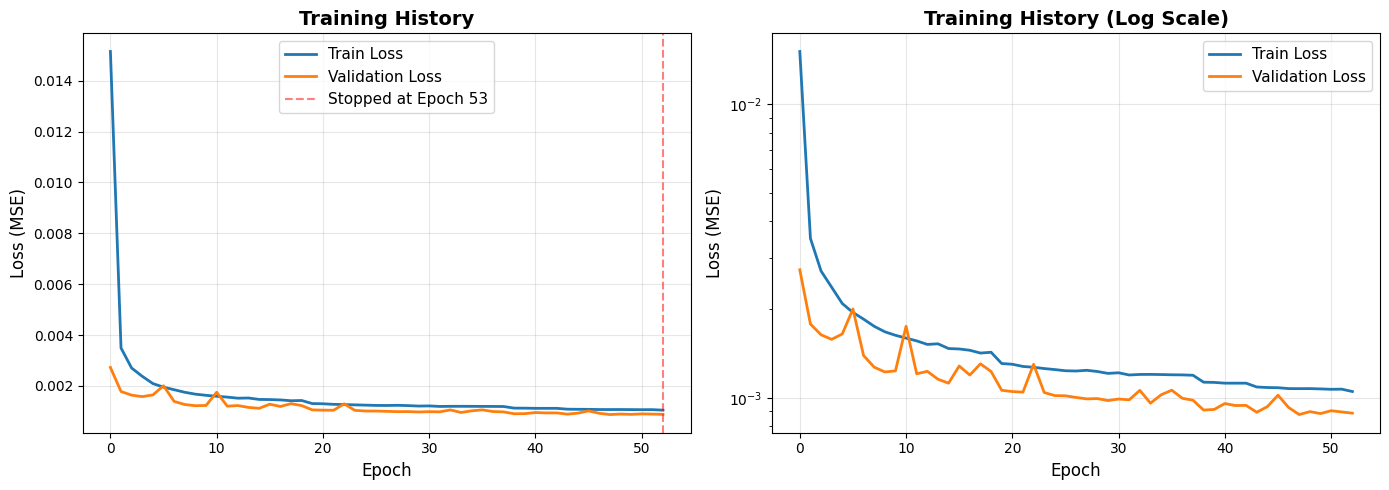

In [33]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.axvline(len(train_losses)-1, color='red', linestyle='--', alpha=0.5,
           label=f'Stopped at Epoch {len(train_losses)}')
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train Loss', linewidth=2)
plt.plot(val_losses, label='Validation Loss', linewidth=2)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss (MSE)', fontsize=12)
plt.title('Training History (Log Scale)', fontsize=14, fontweight='bold')
plt.yscale('log')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

- Timetable (시간축 예측 결과)

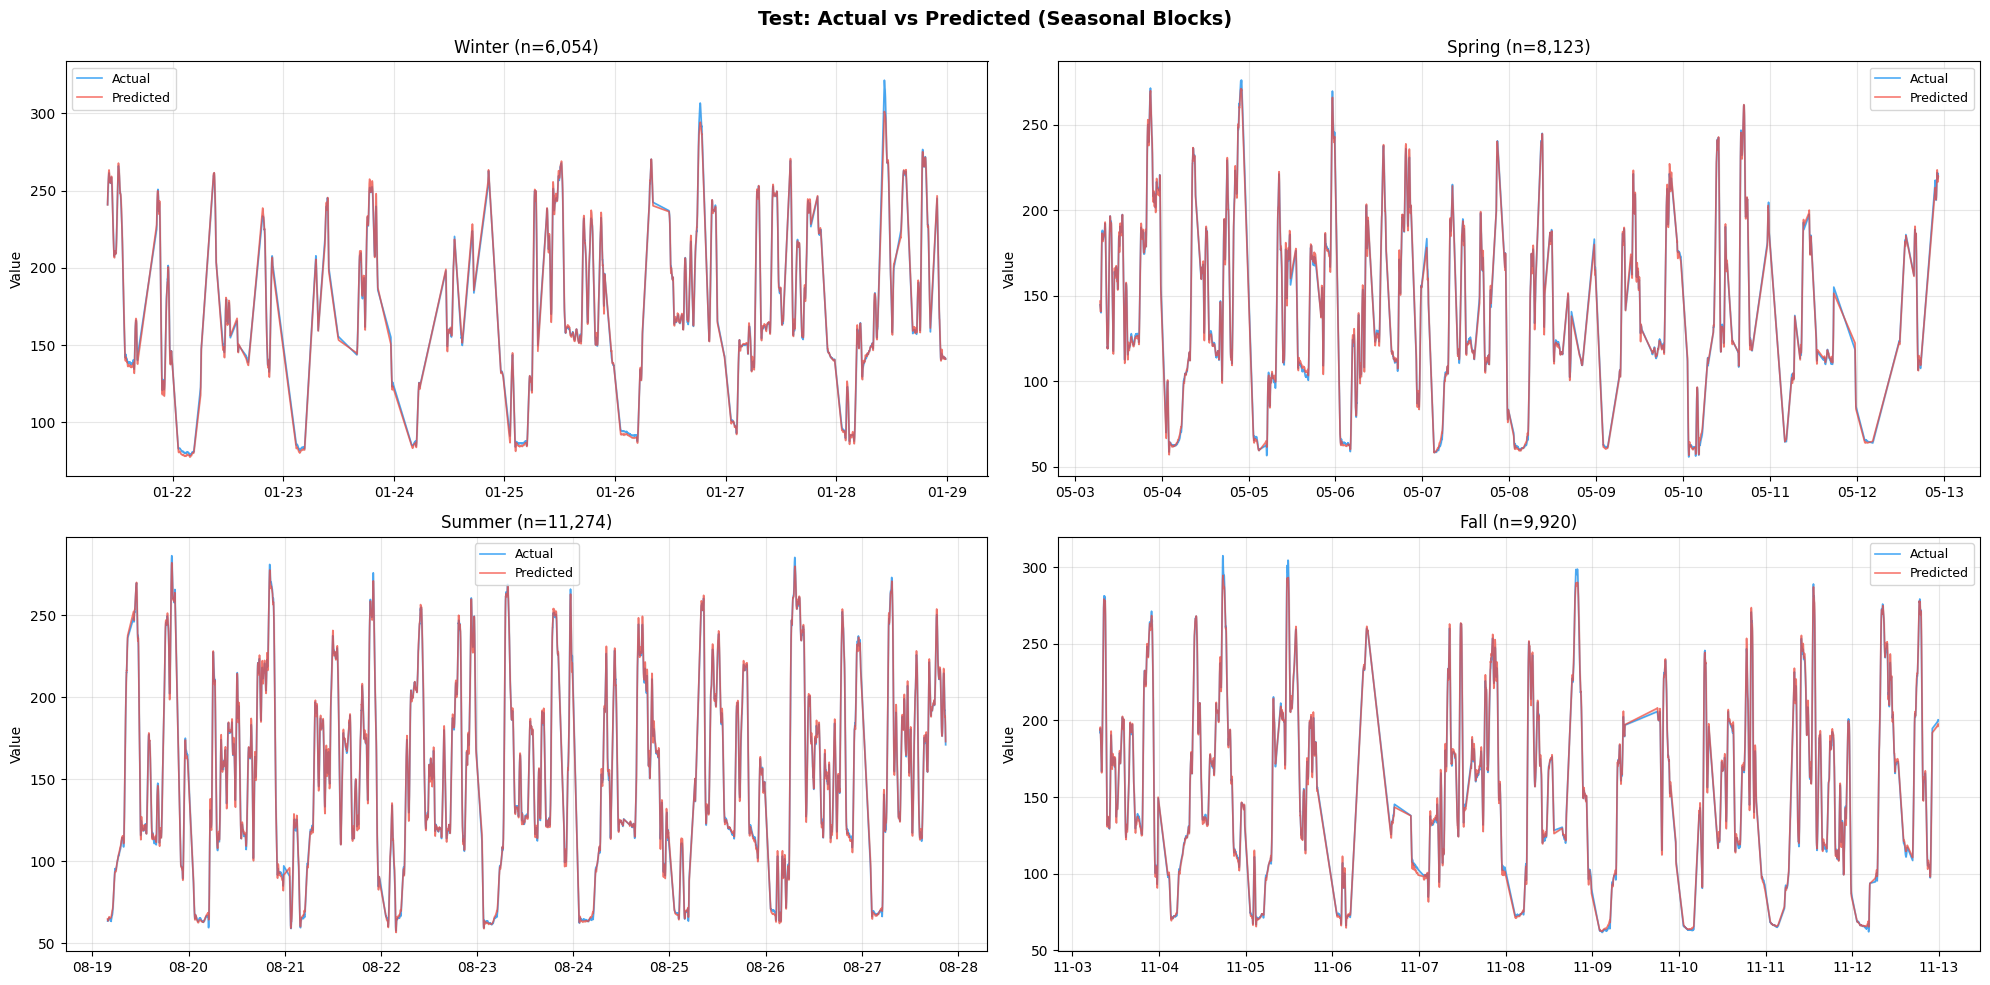

In [26]:
import matplotlib.dates as mdates

actual_series = test_actual_original[:, 0]
pred_series = test_pred_original[:, 0]
plot_times = pd.to_datetime(test_times[:len(actual_series)])

# 2x2 subplot: one per seasonal block
fig, axes = plt.subplots(2, 2, figsize=(20, 10))
fig.suptitle('Test: Actual vs Predicted (Seasonal Blocks)', fontsize=14, fontweight='bold')

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
offset = 0

for ax, name, size in zip(axes.flat, season_names, block_sizes):
    t = plot_times[offset:offset+size]
    a = actual_series[offset:offset+size]
    p = pred_series[offset:offset+size]

    ax.plot(t, a, label='Actual', linewidth=1.2, color='#2196F3', alpha=0.8)
    ax.plot(t, p, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.7)
    ax.fill_between(t, a, p, alpha=0.15, color='gray')
    ax.set_title(f'{name} (n={size:,})', fontsize=12)
    ax.set_ylabel('Value')
    ax.legend(fontsize=9)
    ax.grid(True, alpha=0.3)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    offset += size

plt.tight_layout()
plt.show()


- Step별 MAPE 분석

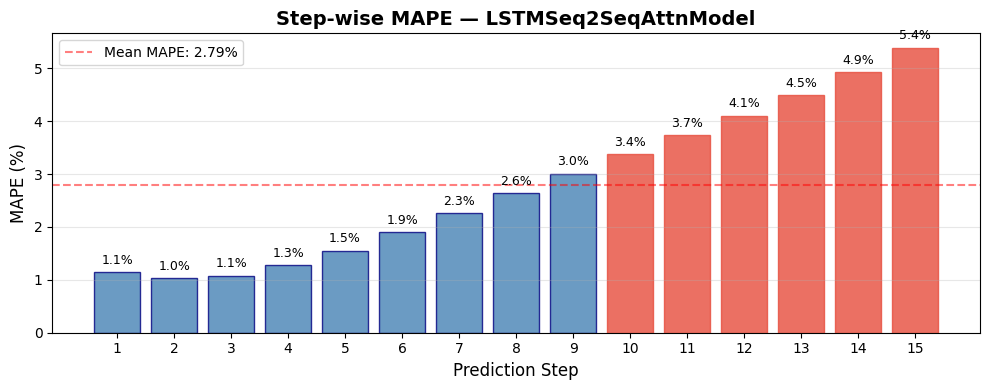


Step-wise MAPE:
  Step  1: 1.14%
  Step  2: 1.03%
  Step  3: 1.08%
  Step  4: 1.28%
  Step  5: 1.55%
  Step  6: 1.90%
  Step  7: 2.25%
  Step  8: 2.63%
  Step  9: 3.01%
  Step 10: 3.37%
  Step 11: 3.73%
  Step 12: 4.10%
  Step 13: 4.50%
  Step 14: 4.93%
  Step 15: 5.39% ← worst
  Mean:   2.79%


In [27]:
# Step별 MAPE 분석 — 후반 step 성능 저하 확인
step_mapes = []
for s in range(output_time):
    actual_s = test_actual_original[:, s]
    pred_s = test_pred_original[:, s]
    mask = actual_s != 0
    mape_s = np.mean(np.abs((actual_s[mask] - pred_s[mask]) / actual_s[mask])) * 100
    step_mapes.append(mape_s)

plt.figure(figsize=(10, 4))
bars = plt.bar(range(1, output_time + 1), step_mapes, color='steelblue', edgecolor='navy', alpha=0.8)

# 색상 강조: MAPE가 높은 step
for i, (bar, mape) in enumerate(zip(bars, step_mapes)):
    if mape > np.mean(step_mapes) * 1.1:  # 평균 대비 10% 이상이면 빨간색
        bar.set_color('#e74c3c')
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f'{mape:.1f}%', ha='center', va='bottom', fontsize=9)

plt.axhline(y=np.mean(step_mapes), color='red', linestyle='--', alpha=0.5, label=f'Mean MAPE: {np.mean(step_mapes):.2f}%')
plt.xlabel('Prediction Step', fontsize=12)
plt.ylabel('MAPE (%)', fontsize=12)
plt.title(f'Step-wise MAPE — {model_name}', fontsize=14, fontweight='bold')
plt.xticks(range(1, output_time + 1))
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print(f"\nStep-wise MAPE:")
for s, mape in enumerate(step_mapes):
    flag = " ← worst" if mape == max(step_mapes) else ""
    print(f"  Step {s+1:2d}: {mape:.2f}%{flag}")
print(f"  Mean:   {np.mean(step_mapes):.2f}%")


### Step 증가에 따른 예측 정확도 감소 추세 분석
- Step이 멀어질수록 예측 오차가 얼마나 증가하는지 정량적 분석
- 계절별 분해: 특정 계절에서 감소가 더 심한지 확인
- MAPE, RMSE, MAE, R², Bias 5개 지표 Step별 추세

Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)

                    MAPE          RMSE           MAE            R2          Bias
----------------------------------------------------------------------
       All  +0.328%/step  +0.775/step  +0.532/step  -0.00318/step  +0.162/step
    Winter  +0.369%/step  +0.842/step  +0.624/step  -0.00406/step  +0.384/step
    Spring  +0.293%/step  +0.705/step  +0.457/step  -0.00306/step  +0.116/step
    Summer  +0.338%/step  +0.778/step  +0.534/step  -0.00321/step  +0.099/step
      Fall  +0.318%/step  +0.786/step  +0.534/step  -0.00306/step  +0.137/step

             Step 1 MAPE   Step 15 MAPE     Ratio   Step 1 R2   Step 15 R2
----------------------------------------------------------------------
       All        1.14%         5.39%      4.7x      0.9987       0.9529
    Winter        1.02%         5.75%      5.6x      0.9983       0.9400
    Spring        1.18%         5.02%      4.3x      0.9987       0.9550
    Summer        1.16%         5.59%      4.8x

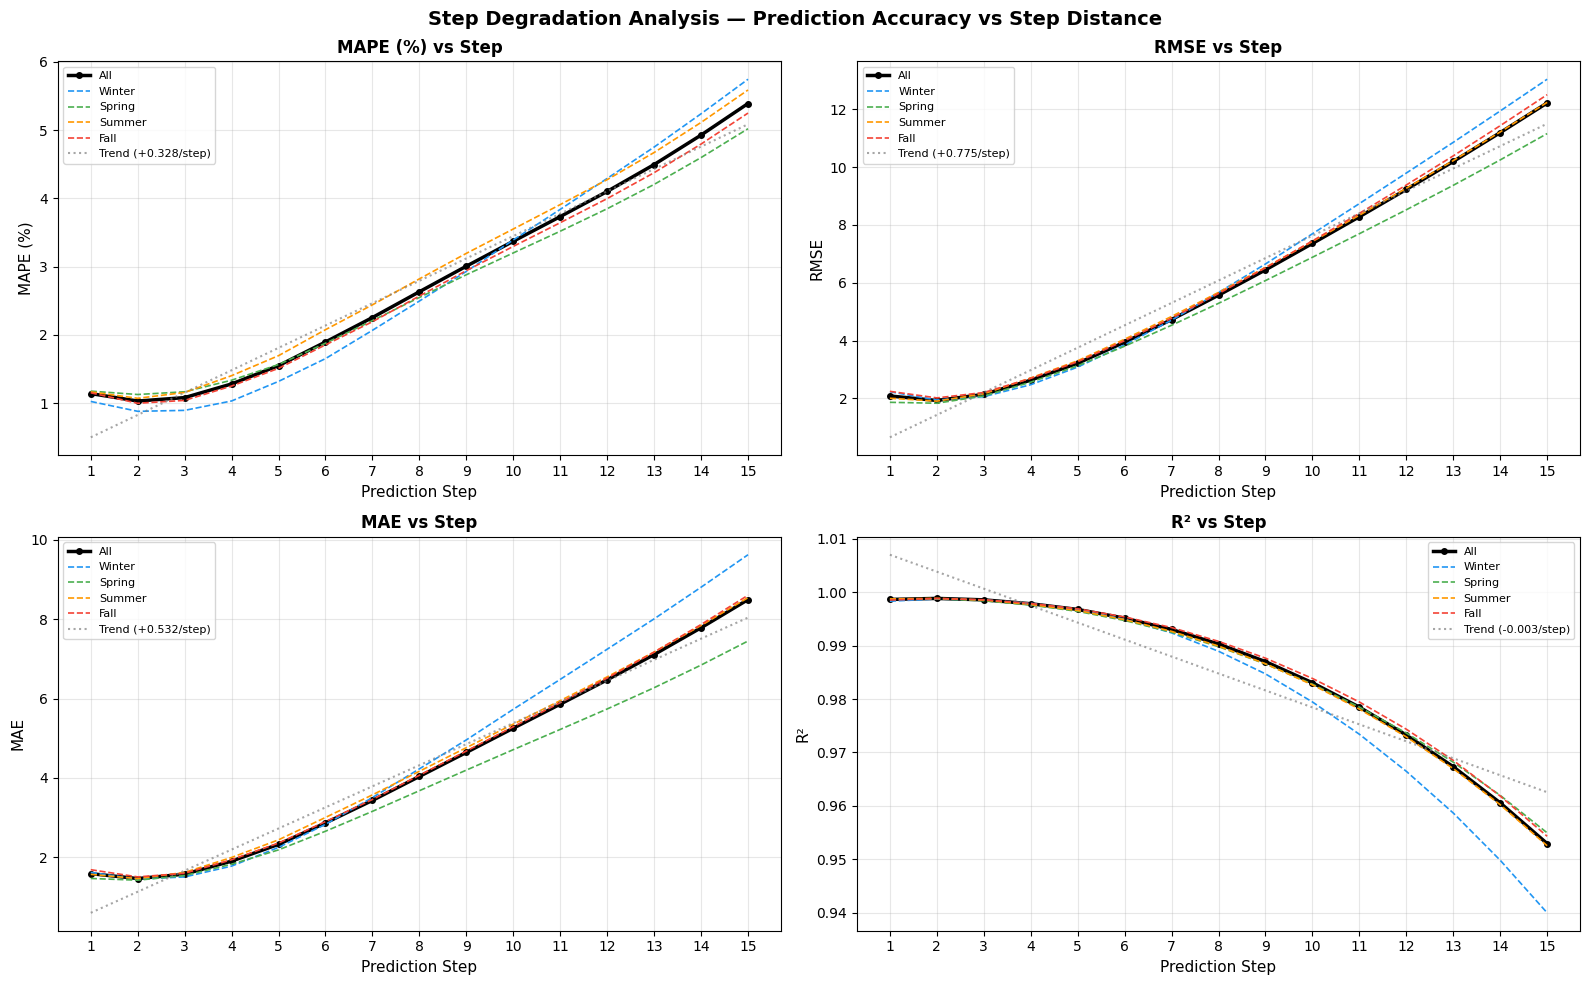


Step-weighted Loss 효과 분석
  Loss weight: Step 1 = 1.0, Step 15 = 2.0
  Step 1 MAPE: 1.14%
  Step 15 MAPE: 5.39%
  Ratio (Step15/Step1): 4.7x
  MAPE 증가율: 0.304%/step

  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 4.7배 증가.


In [28]:
# Step 증가에 따른 예측 정확도 감소 추세 (전체 + 계절별)
from sklearn.metrics import r2_score as r2_fn

season_names = ['Winter', 'Spring', 'Summer', 'Fall']
block_sizes = [len(arr) for arr in X_test_list]
steps = np.arange(1, output_time + 1)

# 1) 전체 + 계절별 Step-wise 지표 계산
results = {}  # {name: {metric: [step1, ..., step15]}}

# 전체
all_metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
for s in range(output_time):
    a = test_actual_original[:, s]
    p = test_pred_original[:, s]
    mask = a != 0
    all_metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
    all_metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
    all_metrics['MAE'].append(np.mean(np.abs(a - p)))
    all_metrics['R2'].append(r2_fn(a, p))
    all_metrics['Bias'].append(np.mean(a - p))
results['All'] = all_metrics

# 계절별
offset = 0
for name, size in zip(season_names, block_sizes):
    block_actual = test_actual_original[offset:offset + size]
    block_pred = test_pred_original[offset:offset + size]
    metrics = {'MAPE': [], 'RMSE': [], 'MAE': [], 'R2': [], 'Bias': []}
    for s in range(output_time):
        a = block_actual[:, s]
        p = block_pred[:, s]
        mask = a != 0
        metrics['MAPE'].append(np.mean(np.abs((a[mask] - p[mask]) / a[mask])) * 100)
        metrics['RMSE'].append(np.sqrt(np.mean((a - p) ** 2)))
        metrics['MAE'].append(np.mean(np.abs(a - p)))
        metrics['R2'].append(r2_fn(a, p))
        metrics['Bias'].append(np.mean(a - p))
    results[name] = metrics
    offset += size

# 2) 선형 회귀로 감소율(기울기) 계산
from numpy.polynomial.polynomial import polyfit
print("=" * 70)
print("Step별 예측 감소 추세 — 선형 회귀 기울기 (step당 변화량)")
print("=" * 70)
print(f"\n{'':>10s}  {'MAPE':>12s}  {'RMSE':>12s}  {'MAE':>12s}  {'R2':>12s}  {'Bias':>12s}")
print("-" * 70)
for name in ['All'] + season_names:
    slopes = {}
    for metric in ['MAPE', 'RMSE', 'MAE', 'R2', 'Bias']:
        b, m = polyfit(steps, results[name][metric], 1)
        slopes[metric] = m
    print(f"{name:>10s}  {slopes['MAPE']:+.3f}%/step  "
          f"{slopes['RMSE']:+.3f}/step  {slopes['MAE']:+.3f}/step  "
          f"{slopes['R2']:+.5f}/step  {slopes['Bias']:+.3f}/step")

# Step 1 vs Step 15 비교
print(f"\n{'':>10s}  {'Step 1 MAPE':>12s}  {'Step 15 MAPE':>13s}  {'Ratio':>8s}  {'Step 1 R2':>10s}  {'Step 15 R2':>11s}")
print("-" * 70)
for name in ['All'] + season_names:
    m1 = results[name]['MAPE'][0]
    m15 = results[name]['MAPE'][-1]
    r1 = results[name]['R2'][0]
    r15 = results[name]['R2'][-1]
    print(f"{name:>10s}  {m1:10.2f}%  {m15:11.2f}%  {m15/m1:7.1f}x  {r1:10.4f}  {r15:11.4f}")

# 3) 시각화: 4개 지표 × (전체 + 계절별)
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Step Degradation Analysis — Prediction Accuracy vs Step Distance',
             fontsize=14, fontweight='bold')

colors = {'All': 'black', 'Winter': '#2196F3', 'Spring': '#4CAF50',
          'Summer': '#FF9800', 'Fall': '#F44336'}
linewidths = {'All': 2.5, 'Winter': 1.2, 'Spring': 1.2, 'Summer': 1.2, 'Fall': 1.2}

for ax, metric, ylabel in zip(axes.flat,
    ['MAPE', 'RMSE', 'MAE', 'R2'],
    ['MAPE (%)', 'RMSE', 'MAE', 'R²']):

    for name in ['All'] + season_names:
        vals = results[name][metric]
        ax.plot(steps, vals, label=name, color=colors[name],
                linewidth=linewidths[name],
                linestyle='-' if name == 'All' else '--',
                marker='o' if name == 'All' else None,
                markersize=4)

    # 전체 추세선
    b, m = polyfit(steps, results['All'][metric], 1)
    trend = b + m * steps
    ax.plot(steps, trend, color='gray', linestyle=':', linewidth=1.5, alpha=0.7,
            label=f'Trend ({m:+.3f}/step)')

    ax.set_xlabel('Prediction Step', fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(f'{ylabel} vs Step', fontsize=12, fontweight='bold')
    ax.set_xticks(steps)
    ax.legend(fontsize=8, loc='best')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# 4) Step-weighted Loss 효과 분석
print("\n" + "=" * 70)
print("Step-weighted Loss 효과 분석")
print("=" * 70)
print(f"  Loss weight: Step 1 = 1.0, Step 15 = 2.0")
print(f"  Step 1 MAPE: {results['All']['MAPE'][0]:.2f}%")
print(f"  Step 15 MAPE: {results['All']['MAPE'][-1]:.2f}%")
print(f"  Ratio (Step15/Step1): {results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}x")
print(f"  MAPE 증가율: {(results['All']['MAPE'][-1]-results['All']['MAPE'][0])/(output_time-1):.3f}%/step")
print(f"\n  해석: Step 1(1분 후)에서 Step 15(15분 후)로 갈수록 MAPE가 "
      f"{results['All']['MAPE'][-1]/results['All']['MAPE'][0]:.1f}배 증가.")

### 45d 삼각형 구간 비교 분석 (Spring 04-25~04-27, Fall 10-23~10-27)
- 45d 모델에서 block boundary 끝부분에 회색 삼각형이 발생한 구간
- 60d에서는 데이터 확장으로 해당 날짜가 Train/Val에 흡수 — Test 범위가 달라짐
- 해당 구간이 test에 없으면 60d의 실제 test 경계 구간을 분석



60d 모델 — Test 경계 구간 (마지막 3일) 상세 분석

[Winter] Test 마지막 3일: 2024-01-25 ~ 2024-01-28 (2,977개)
  Mean MAPE: 2.85% (전체: 2.79%)
  Mean Bias: +2.67
  Step 1: 0.90% → Step 15: 5.87%

[Spring] Test 마지막 3일: 2024-05-09 ~ 2024-05-12 (1,449개)
  Mean MAPE: 2.73% (전체: 2.79%)
  Mean Bias: +0.82
  Step 1: 1.21% → Step 15: 5.21%

[Summer] Test 마지막 3일: 2023-08-24 ~ 2023-08-27 (3,828개)
  Mean MAPE: 3.08% (전체: 2.79%)
  Mean Bias: +0.68
  Step 1: 1.18% → Step 15: 5.86%

[Fall] Test 마지막 3일: 2023-11-10 ~ 2023-11-12 (3,186개)
  Mean MAPE: 2.70% (전체: 2.79%)
  Mean Bias: +0.11
  Step 1: 1.15% → Step 15: 5.13%


/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 47784 (\N{HANGUL SYLLABLE MO}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 45944 (\N{HANGUL SYLLABLE DEL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 44221 (\N{HANGUL SYLLABLE GYEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 44396 (\N{HANGUL SYLLABLE GU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/3802435600.py:91: UserWarning: Glyph 47560 (\N{HANGUL SYLLABLE MA}) missing from font(s) DejaVu Sans.

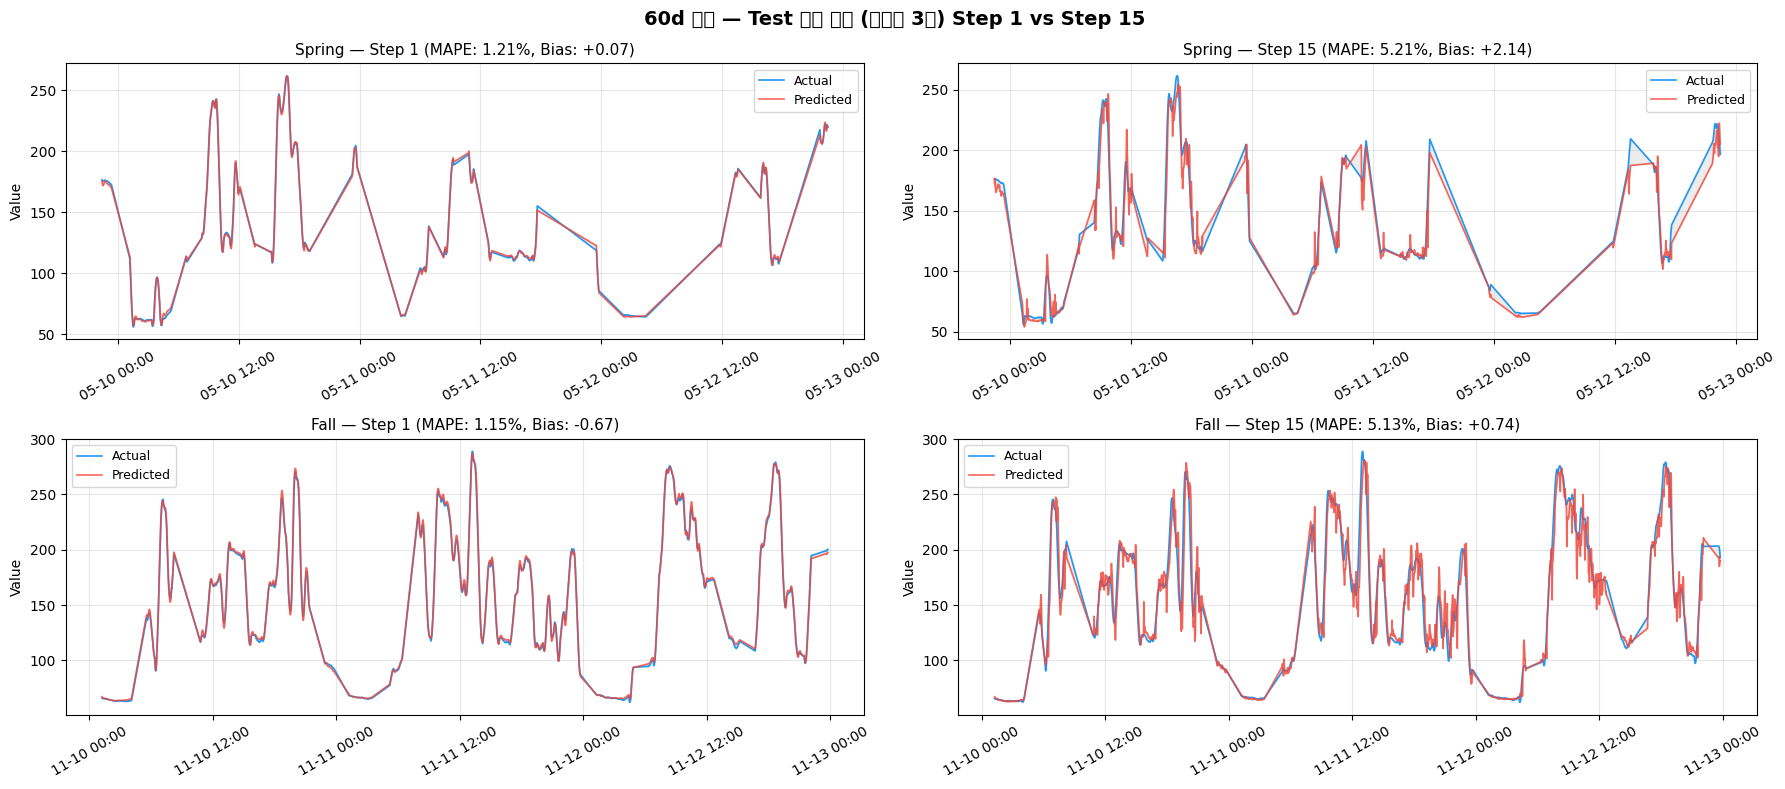

In [29]:
# 45d 삼각형 구간 → 60d에서 위치 확인 + test 경계 구간 분석
import matplotlib.dates as mdates

# 1) 60d test 경계 구간(마지막 3일) 상세 분석
print("\n\n" + "=" * 70)
print("60d 모델 — Test 경계 구간 (마지막 3일) 상세 분석")
print("=" * 70)

# season_names, block_sizes, plot_times는 이전 셀에서 정의됨
for season_name in season_names:
    season_idx = season_names.index(season_name)
    offset = sum(block_sizes[:season_idx])
    block_size = block_sizes[season_idx]

    block_times_arr = plot_times[offset:offset + block_size]
    block_actual = test_actual_original[offset:offset + block_size]
    block_pred = test_pred_original[offset:offset + block_size]

    # 마지막 3일
    last_time = block_times_arr[-1]
    boundary_start = last_time - pd.Timedelta(days=3)
    mask = block_times_arr >= boundary_start
    indices = np.where(mask)[0]

    target_actual = block_actual[indices]
    target_pred = block_pred[indices]
    target_times = block_times_arr[indices]

    date_s = str(pd.Timestamp(target_times[0]).date())
    date_e = str(pd.Timestamp(target_times[-1]).date())

    print(f"\n[{season_name}] Test 마지막 3일: {date_s} ~ {date_e} ({len(indices):,}개)")

    step_mapes_range = []
    for s in range(output_time):
        a = target_actual[:, s]
        p = target_pred[:, s]
        mask_nz = a != 0
        mape_s = np.mean(np.abs((a[mask_nz] - p[mask_nz]) / a[mask_nz])) * 100
        step_mapes_range.append(mape_s)

    mean_mape = np.mean(step_mapes_range)
    mean_bias = np.mean(target_actual - target_pred)
    print(f"  Mean MAPE: {mean_mape:.2f}% (전체: {test_mape:.2f}%)")
    print(f"  Mean Bias: {mean_bias:+.2f}")
    print(f"  Step 1: {step_mapes_range[0]:.2f}% → Step 15: {step_mapes_range[-1]:.2f}%")

# 2) Spring/Fall test 경계 시각화
fig, axes = plt.subplots(2, 2, figsize=(18, 8))
fig.suptitle('60d 모델 — Test 경계 구간 (마지막 3일) Step 1 vs Step 15',
             fontsize=14, fontweight='bold')

for ax_row, season_name in zip(axes, ['Spring', 'Fall']):
    season_idx = season_names.index(season_name)
    offset = sum(block_sizes[:season_idx])
    block_size = block_sizes[season_idx]

    block_times_arr = plot_times[offset:offset + block_size]
    block_actual = test_actual_original[offset:offset + block_size]
    block_pred = test_pred_original[offset:offset + block_size]

    last_time = block_times_arr[-1]
    boundary_start = last_time - pd.Timedelta(days=3)
    mask = block_times_arr >= boundary_start
    indices = np.where(mask)[0]

    target_actual = block_actual[indices]
    target_pred = block_pred[indices]
    target_times = block_times_arr[indices]

    for ax, step_idx in zip(ax_row, [0, 14]):
        t = target_times
        a = target_actual[:, step_idx]
        p = target_pred[:, step_idx]

        ax.plot(t, a, label='Actual', linewidth=1.2, color='#2196F3')
        ax.plot(t, p, label='Predicted', linewidth=1.2, color='#F44336', alpha=0.8)
        ax.fill_between(t, a, p, alpha=0.15, color='gray')

        mask_nz = a != 0
        mape_s = np.mean(np.abs((a[mask_nz] - p[mask_nz]) / a[mask_nz])) * 100
        bias_s = np.mean(a - p)
        ax.set_title(f'{season_name} — Step {step_idx+1} (MAPE: {mape_s:.2f}%, Bias: {bias_s:+.2f})',
                     fontsize=11)
        ax.set_ylabel('Value')
        ax.legend(fontsize=9)
        ax.grid(True, alpha=0.3)
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d %H:%M'))
        ax.tick_params(axis='x', rotation=30)

plt.tight_layout()
plt.show()

### Bahdanau Attention Heatmap — Step별 Attention Weight 차별화 확인
- 기존 Cross-Attention: weight ≈ uniform (1/72) — Query가 h₇₂로 고정
- **Seq2Seq Attention: step마다 Query가 다름 → weight 차별화 기대**
- step 1: 최근 timestep(h₇₁, h₇₂)에 집중?
- step 15: 더 넓은 범위에 분산?

/tmp/ipykernel_109668/4125429026.py:36: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/tmp/ipykernel_109668/4125429026.py:36: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/home/kp/web/work/pro/314env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48516 (\N{HANGUL SYLLABLE BUN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/home/kp/web/work/pro/314env/lib/python3.14/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 54980 (\N{HANGUL SYLLABLE HU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


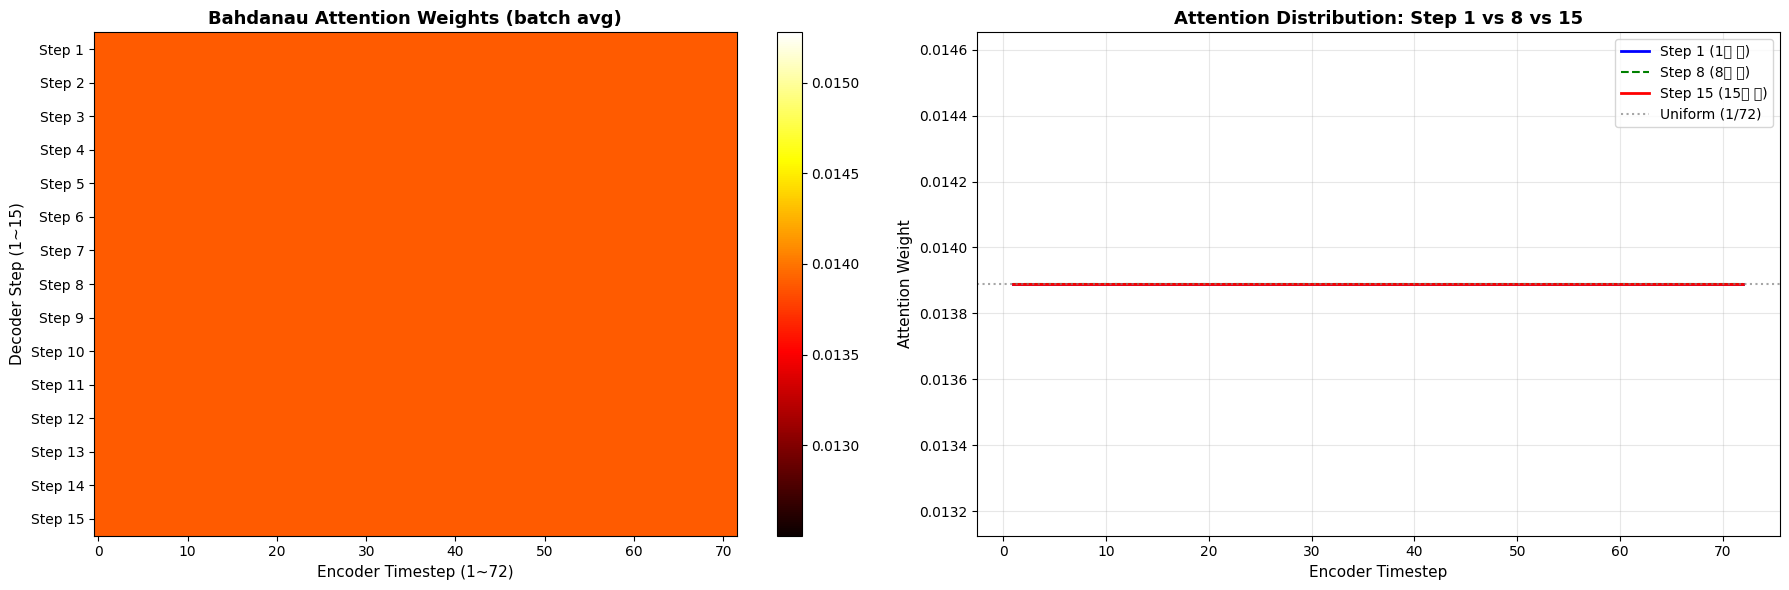


=== Attention 차별화 분석 ===
Uniform weight: 0.0139

Step 1:
  Max weight: 0.0139 (timestep 1)
  Min weight: 0.0139
  Max/Min ratio: 1.00x
  Top-5 timesteps: [0, 1, 2, 3, 4]
  Entropy: 4.277 (uniform=4.277)

Step 8:
  Max weight: 0.0139 (timestep 1)
  Min weight: 0.0139
  Max/Min ratio: 1.00x
  Top-5 timesteps: [0, 1, 2, 3, 4]
  Entropy: 4.277 (uniform=4.277)

Step 15:
  Max weight: 0.0139 (timestep 1)
  Min weight: 0.0139
  Max/Min ratio: 1.00x
  Top-5 timesteps: [0, 1, 2, 3, 4]
  Entropy: 4.277 (uniform=4.277)


In [30]:
# Bahdanau Attention Heatmap 시각화
import matplotlib.pyplot as plt

model.eval()
with torch.no_grad():
    # 테스트 첫 배치로 attention weights 추출
    sample_X, _ = next(iter(test_loader))
    _ = model(sample_X)
    attn_weights = model.attn_weights_all  # (batch, 15, 72)

# 배치 평균
avg_attn = attn_weights.mean(dim=0).cpu().numpy()  # (15, 72)

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# 1) Heatmap
im = axes[0].imshow(avg_attn, aspect='auto', cmap='hot', interpolation='nearest')
axes[0].set_xlabel('Encoder Timestep (1~72)', fontsize=11)
axes[0].set_ylabel('Decoder Step (1~15)', fontsize=11)
axes[0].set_title('Bahdanau Attention Weights (batch avg)', fontsize=13, fontweight='bold')
axes[0].set_yticks(range(output_time))
axes[0].set_yticklabels([f'Step {i+1}' for i in range(output_time)])
plt.colorbar(im, ax=axes[0])

# 2) Step 1 vs Step 15 attention 분포 비교
axes[1].plot(range(1, input_time+1), avg_attn[0], label='Step 1 (1분 후)', linewidth=2, color='blue')
axes[1].plot(range(1, input_time+1), avg_attn[7], label='Step 8 (8분 후)', linewidth=1.5, color='green', linestyle='--')
axes[1].plot(range(1, input_time+1), avg_attn[-1], label='Step 15 (15분 후)', linewidth=2, color='red')
axes[1].axhline(y=1/input_time, color='gray', linestyle=':', label=f'Uniform (1/{input_time})', alpha=0.7)
axes[1].set_xlabel('Encoder Timestep', fontsize=11)
axes[1].set_ylabel('Attention Weight', fontsize=11)
axes[1].set_title('Attention Distribution: Step 1 vs 8 vs 15', fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Attention 차별화 정량 분석
print("\n=== Attention 차별화 분석 ===")
print(f"Uniform weight: {1/input_time:.4f}")
for s_idx, s_name in [(0, 'Step 1'), (7, 'Step 8'), (14, 'Step 15')]:
    w = avg_attn[s_idx]
    print(f"\n{s_name}:")
    print(f"  Max weight: {w.max():.4f} (timestep {w.argmax()+1})")
    print(f"  Min weight: {w.min():.4f}")
    print(f"  Max/Min ratio: {w.max()/w.min():.2f}x")
    print(f"  Top-5 timesteps: {sorted(range(len(w)), key=lambda i: w[i], reverse=True)[:5]}")
    # Entropy (균일하면 log(72)=4.28, 집중하면 낮음)
    import numpy as np
    entropy = -np.sum(w * np.log(w + 1e-10))
    print(f"  Entropy: {entropy:.3f} (uniform={np.log(input_time):.3f})")


- Final Summary & 모델 저장

In [31]:
test_ratio = 1.0 - train_ratio - val_ratio

print("\n" + "="*60)
print(f"Final Summary ({model_name})")
print("="*60)
print(f"Features: {feature_cols}")
print(f"Data: {len(df_merged):,}행 (flow+weather inner merge)")
print(f"Data Split: Train {train_ratio*100:.0f}% / Val {val_ratio*100:.0f}% / Test {test_ratio*100:.0f}%")
print(f"Split Gap: {split_gap} steps (data leak 방지)")
print(f"Stopped at Epoch: {len(train_losses)}")
print(f"Best Val Loss: {early_stopping.best_loss:.6f}")
print(f"Test Loss: {avg_test_loss:.6f}")
print(f"Test RMSE: {test_rmse:.4f}")
print(f"Test MAE: {test_mae:.4f}")
print(f"Test MAPE: {test_mape:.2f}%")
print(f"Test R²: {test_r2:.4f}")
print(f"Mean Error (Bias): {np.mean(test_actual_original - test_pred_original):.4f}")
print("="*60)


Final Summary (LSTMSeq2SeqAttnModel)
Features: ['value', 'temperature', 'rainfall', 'humidity', 'time_sin', 'time_cos', 'dow_sin', 'dow_cos', 'season_sin', 'season_cos']
Data: 323,308행 (flow+weather inner merge)
Data Split: Train 70% / Val 15% / Test 15%
Split Gap: 87 steps (data leak 방지)
Stopped at Epoch: 53
Best Val Loss: 0.000876
Test Loss: 0.000900
Test RMSE: 6.9614
Test MAE: 4.3200
Test MAPE: 2.79%
Test R²: 0.9849
Mean Error (Bias): 0.8613


In [32]:
model_path = BASE_DIR / "models" / "lstm_seq2seq_attn_60d.pth"

torch.save({
    'model_name': model_name,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'scalers': {col: {'min': scalers[col].data_min_[0], 'max': scalers[col].data_max_[0]} for col in scale_cols},
    'feature_cols': feature_cols,
    'scale_cols': scale_cols,
    'train_losses': train_losses,
    'val_losses': val_losses,
    'test_loss': avg_test_loss,
    'best_epoch': len(train_losses),
    'input_time': input_time,
    'output_time': output_time,
}, model_path)

print(f"모델 저장 완료: {model_path}")


모델 저장 완료: /home/kp/web/work/pro/models/lstm_seq2seq_attn_60d.pth
